In [ ]:
!pip install --upgrade tensorflow

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf

def read_file(filename):
    df = pd.read_csv(filename)                                    

    data_x = np.stack([ik
        df['Temperature'].values,
        df['Humidity'].values,
        df['Light'].values,
        df['CO2'].values,
        df['HumidityRatio'].values,
        ],axis=-1)
    data_y = df['Occupancy'].values.astype(np.int32)
    return data_x,data_y

def cut_in_sequences(x,y,seq_len,inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0,x.shape[0] - seq_len,inc):
        start = s
        end = start+seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x,axis=1),np.stack(sequences_y,axis=1)

seq_len=16
train_x,train_y = read_file("data/occupancy/datatraining.txt")
test0_x,test0_y = read_file("data/occupancy/datatest.txt")
test1_x,test1_y = read_file("data/occupancy/datatest2.txt")

mean_x = np.mean(train_x,axis=0)
std_x = np.std(train_x,axis=0)
train_x = (train_x-mean_x)/std_x
test0_x = (test0_x-mean_x)/std_x
test1_x = (test1_x-mean_x)/std_x

train_x,train_y = cut_in_sequences(train_x,train_y,seq_len)
test0_x,test0_y = cut_in_sequences(test0_x,test0_y,seq_len,inc=8)
test1_x,test1_y = cut_in_sequences(test1_x,test1_y,seq_len,inc=8)
print("Total number of training sequences: {}".format(train_x.shape[1]))
permutation = np.random.RandomState(893429).permutation(train_x.shape[1])
valid_size = int(0.1*train_x.shape[1])
print("Validation split: {}, training split: {}".format(valid_size,train_x.shape[1]-valid_size))

valid_x = train_x[:,permutation[:valid_size]]
valid_y = train_y[:,permutation[:valid_size]]
train_x = train_x[:,permutation[valid_size:]]
train_y = train_y[:,permutation[valid_size:]]

test_x = np.concatenate([test0_x,test1_x],axis=1)
test_y = np.concatenate([test0_y,test1_y],axis=1)
print("Total number of test sequences: {}".format(test_x.shape[1]))

Total number of training sequences: 8127
Validation split: 812, training split: 7315
Total number of test sequences: 1549


In [ ]:
pip install keras-ncp

In [3]:
from tensorflow import keras
from kerasncp import wirings
from kerasncp.tf import LTCCell
import matplotlib.pyplot as plt
import seaborn as sns

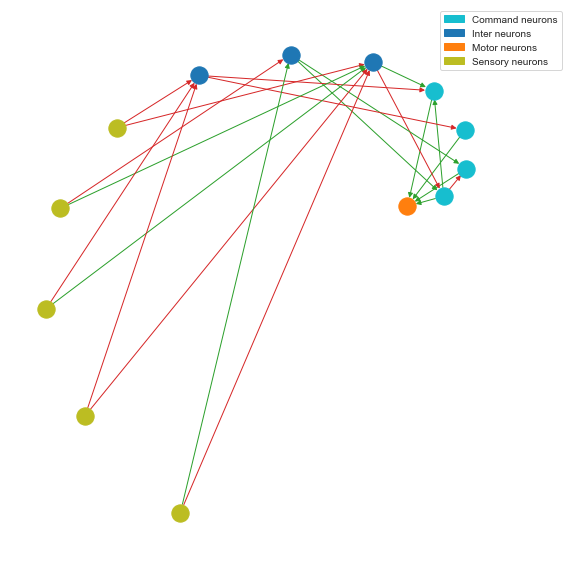

In [12]:
ncp_arch = wirings.NCP(
    inter_neurons=3,  # Number of inter neurons
    command_neurons=4,  # Number of command neurons
    motor_neurons=1,  # Number of motor neurons
    sensory_fanout=2,  # How many outgoing synapses has each sensory neuron
    inter_fanout=2,  # How many outgoing synapses has each inter neuron
    recurrent_command_synapses=3,  # Now many recurrent synapses are in the
    # command neuron layer
    motor_fanin=4,  # How many incomming syanpses has each motor neuron
)
ncp_cell = LTCCell(ncp_arch)

ncp_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 5)),
        keras.layers.RNN(ncp_cell, return_sequences=True),
    ]
)
ncp_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

sns.set_style("white")
plt.figure(figsize=(8, 8))
legend_handles = ncp_cell.draw_graph(layout='spiral',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [ ]:
hist_ncp = ncp_model.fit(x=train_x, y=train_y, batch_size=1, epochs=100,verbose=0)

In [ ]:
sns.set()
plt.figure(figsize=(6, 4))
plt.plot()
plt.plot(hist_ncp.history["loss"],label='ncp')
data_ltc_gesture = np.loadtxt('ltc_train_loss_occupancy.txt')
x_ltc_gesture = data_ltc_gesture[:, 0]
y_ltc_gesture = data_ltc_gesture[:, 1]
plt.plot(x_ltc_gesture, y_ltc_gesture,'r',label="original-ltc")
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
sparsity = 1 - ncp_cell.synapse_count /ltc_cell.synapse_count
print("Sparsity level is {:0.2f}%".format(100*sparsity))